In [1]:
!pip install google-cloud-bigquery pyarrow pandas -q

In [3]:
# @title Setup
from google.cloud import bigquery
from google.colab import data_table
import bigframes.pandas as bpd

project = 'md-ga4-marketing-analysis' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()

**Pull the data into Python (Colab + BigQuery client)**

In [4]:
import pandas as pd
from google.cloud import bigquery

PROJECT = "md-ga4-marketing-analysis"
DATASET = "ga4_campaign_data"
TABLE   = "fact_campaign_performance"

client = bigquery.Client(project=PROJECT)

sql = f"""
SELECT
  event_date,
  source,
  medium,
  campaign,
  impressions,
  clicks,
  sessions,
  conversions,
  conversions_incl_null,
  revenue,
  ctr,
  cvr,
  aov,
  session_to_purchase_rate,
  cvr_incl_null,
  aov_incl_null
FROM `{PROJECT}.{DATASET}.{TABLE}`
-- Optional: filter a window
-- WHERE event_date BETWEEN DATE('2024-01-01') AND DATE('2024-06-30')
"""
df = client.query(sql).to_dataframe()
df.head()


,event_date,source,medium,campaign,impressions,clicks,sessions,conversions,conversions_incl_null,revenue,ctr,cvr,aov,session_to_purchase_rate,cvr_incl_null,aov_incl_null
0,2020-12-17,robertsonmarketing.com,referral,(referral),0,0,1,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-17,None,organic,(organic),0,0,6,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-17,shop.googlemerchandisestore.com,organic,(organic),0,0,15,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-17,None,None,None,0,0,1170,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-17,None,None,None,0,0,0,1,1,195.0,NaN,NaN,195.0,NaN,NaN,195.0


**2) Quick sanity checks (types, nulls, ranges)**

In [5]:
df.info()
df.describe()

# Date range check
print(df["event_date"].min(), df["event_date"].max())

# Null audit
df.isna().mean().sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   event_date                3209 non-null   dbdate 
 1   source                    2811 non-null   object 
 2   medium                    2962 non-null   object 
 3   campaign                  2934 non-null   object 
 4   impressions               3209 non-null   Int64  
 5   clicks                    3209 non-null   Int64  
 6   sessions                  3209 non-null   Int64  
 7   conversions               3209 non-null   Int64  
 8   conversions_incl_null     3209 non-null   Int64  
 9   revenue                   3209 non-null   float64
 10  ctr                       2625 non-null   float64
 11  cvr                       401 non-null    float64
 12  aov                       411 non-null    float64
 13  session_to_purchase_rate  401 non-null    float64
 14  cvr_incl

,0
session_to_purchase_rate,0.875039
cvr_incl_null,0.875039
cvr,0.875039
aov,0.871923
aov_incl_null,0.862886
ctr,0.181988
source,0.124026
campaign,0.085696
medium,0.076971
conversions,0.000000


**Cleaning Data Cell**

In [6]:
# 1. Fix dates
df["event_date"] = pd.to_datetime(df["event_date"])

# 2. Fill nulls in categorical fields
df["source"]   = df["source"].fillna("(none)")
df["medium"]   = df["medium"].fillna("(none)")
df["campaign"] = df["campaign"].fillna("(none)")

# 3. Create a clean "channel" label
df["channel"] = df["source"] + " / " + df["medium"]

# 4. Recompute core KPIs from raw columns (ignoring pre-computed ones)
df["CTR_calc"] = df["clicks"] / df["impressions"].replace(0, pd.NA)
df["CVR_calc"] = df["conversions"] / df["clicks"].replace(0, pd.NA)
df["AOV_calc"] = df["revenue"] / df["conversions"].replace(0, pd.NA)

# 5. Sanity check aggregates
summary = (df.groupby("channel", as_index=False)
             [["impressions","clicks","conversions","revenue"]].sum())
summary["CTR"] = summary["clicks"] / summary["impressions"].replace(0, pd.NA)
summary["CVR"] = summary["conversions"] / summary["clicks"].replace(0, pd.NA)
summary["AOV"] = summary["revenue"] / summary["conversions"].replace(0, pd.NA)

summary.sort_values("revenue", ascending=False).head(10)


,channel,impressions,clicks,conversions,revenue,CTR,CVR,AOV
5,(none) / (none),866937,498,2510,234993.0,0.000574,5.040161,93.622709
240,shop.googlemerchandisestore.com / referral,203121,741,1099,73525.0,0.003648,1.483131,66.901729
183,google / organic,122064,54,293,18165.0,0.000442,5.425926,61.996587
3,(direct) / (none),52634,40,231,13358.0,0.00076,5.775,57.82684
82,<Other> / <Other>,35467,25,123,7518.0,0.000705,4.92,61.121951
85,<Other> / referral,26402,25,77,6874.0,0.000947,3.08,89.272727
0,(data deleted) / (data deleted),8641,27,84,4999.0,0.003125,3.111111,59.511905
181,google / cpc,10867,8,32,1739.0,0.000736,4.0,54.34375
84,<Other> / organic,6524,8,19,1232.0,0.001226,2.375,64.842105
177,getpocket.com / referral,0,0,0,0.0,<NA>,<NA>,<NA>


**Rule-based Attribution Leaderboards**

In [23]:
# By channel
by_channel = (df.groupby("channel", as_index=False)
                [["impressions","clicks","conversions","revenue"]].sum())
by_channel["CTR"] = by_channel["clicks"] / by_channel["impressions"].replace(0, pd.NA)
by_channel["CVR"] = by_channel["conversions"] / by_channel["clicks"].replace(0, pd.NA)
by_channel["AOV"] = by_channel["revenue"] / by_channel["conversions"].replace(0, pd.NA)

# Campaign-level aggregates
by_campaign = (df.groupby(["channel","campaign"], as_index=False)
                 [["impressions","clicks","conversions","revenue"]].sum())

# Recompute ratios
by_campaign["CTR"] = by_campaign["clicks"] / by_campaign["impressions"].replace(0, pd.NA)
by_campaign["CVR"] = by_campaign["conversions"] / by_campaign["clicks"].replace(0, pd.NA)
by_campaign["AOV"] = by_campaign["revenue"] / by_campaign["conversions"].replace(0, pd.NA)

# Sort and view
by_channel.sort_values("revenue", ascending=False).head(10)

# Export code
by_channel.to_csv("/content/by_channel_baseline.csv", index=False)
by_campaign.to_csv("/content/by_campaign_baseline.csv", index=False)

from google.colab import files
files.download("/content/by_channel_baseline.csv")
files.download("/content/by_campaign_baseline.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Regression-Based Attribution (Incremental Contribution by Channel)**

Top channels by incremental coefficient (per-click contribution to conversions):


,channel,coef,coef_pos,attribution_share
0,google / cpc,15.688123,15.688123,0.444130
1,<Other> / organic,8.244302,8.244302,0.233396
2,googlemerchandisestore.com / referral,3.715003,3.715003,0.105172
3,(none) / (none),2.956781,2.956781,0.083706
4,<Other> / <Other>,2.105865,2.105865,0.059617
5,<Other> / referral,2.034676,2.034676,0.057602
6,(direct) / (none),0.435440,0.435440,0.012327
7,google / organic,0.143040,0.143040,0.004049
8,(data deleted) / organic,0.000000,0.000000,0.000000
9,(data deleted) / referral,0.000000,0.000000,0.000000


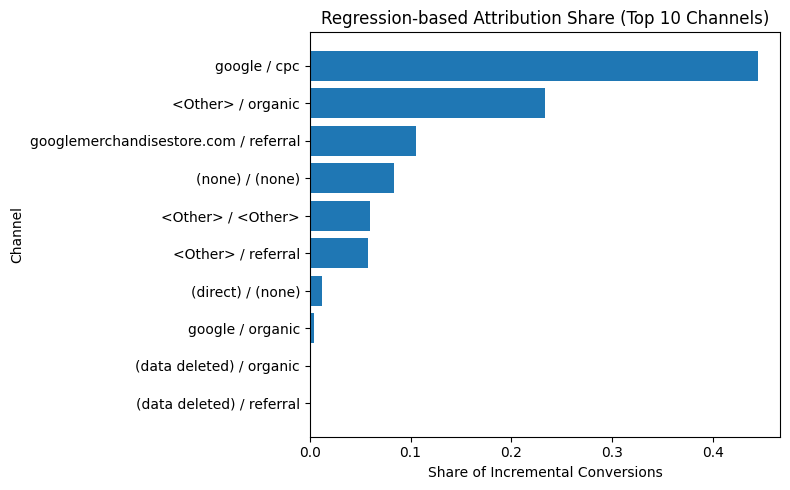

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

# 1) Build daily x channel exposure matrix (using clicks as exposure)
daily = (df.groupby(["event_date", "channel"], as_index=False)[["clicks"]].sum())

# Pivot to wide: columns are channels, values are clicks per day (fill missing with 0)
X = daily.pivot(index="event_date", columns="channel", values="clicks").fillna(0)

# Outcome: total daily conversions across all channels
y = (df.groupby("event_date")["conversions"].sum()
       .reindex(X.index)
       .fillna(0))

# 2) Add simple time controls: day-of-week dummies and linear trend
dt = pd.to_datetime(X.index)
X_ctrl = X.copy()
X_ctrl["dow"]   = dt.dayofweek                         # 0=Mon ... 6=Sun
X_ctrl["trend"] = np.arange(len(X_ctrl))               # linear time trend
X_ctrl = pd.get_dummies(X_ctrl, columns=["dow"], drop_first=True)

# 3) Fit a regularized linear model to handle multicollinearity
#    (alphas can be tuned; RidgeCV picks the best by CV)
model = RidgeCV(alphas=[0.1, 1.0, 10.0])
model.fit(X_ctrl, y)

# 4) Extract coefficients; keep only channel columns (exclude controls)
coef_series = pd.Series(model.coef_, index=X_ctrl.columns)
channel_coefs = coef_series.loc[X.columns]  # same order as original channel set

# 5) Create an attribution table
attr = (channel_coefs.rename("coef")
        .reset_index()
        .rename(columns={"index": "channel"}))

# Interpretation:
# - coef ≈ incremental conversions per additional click from that channel (holding others constant)
# Normalize to a positive-share view for an easy "attribution share" (negatives treated as 0 for share calc)
attr["coef_pos"] = attr["coef"].clip(lower=0)
total_pos = attr["coef_pos"].sum()
attr["attribution_share"] = np.where(total_pos > 0, attr["coef_pos"] / total_pos, 0.0)

# Rank for presentation
attr_sorted = attr.sort_values(["coef_pos", "coef"], ascending=False).reset_index(drop=True)

# 6) Display top channels
print("Top channels by incremental coefficient (per-click contribution to conversions):")
display(attr_sorted.head(15))

# 7) Quick bar chart of attribution shares (top 10)
topN = 10
top_plot = attr_sorted.head(topN).sort_values("attribution_share", ascending=True)
plt.figure(figsize=(8, 5))
plt.barh(top_plot["channel"], top_plot["attribution_share"])
plt.title("Regression-based Attribution Share (Top 10 Channels)")
plt.xlabel("Share of Incremental Conversions")
plt.ylabel("Channel")
plt.tight_layout()
plt.show()

# 8) Export code
attr_sorted.to_csv("/content/regression_attribution_channels.csv", index=False)

from google.colab import files
files.download("/content/regression_attribution_channels.csv")

**A/B-style Difference-in-Differences (DiD) for a Channel/Campaign Change**

=== Difference-in-Differences Result (channel='google / cpc', outcome='conversions') ===
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       52.3998      7.778      6.737      0.000      37.155      67.645
treated        -60.1591      6.303     -9.545      0.000     -72.512     -47.806
post           -38.9317     13.610     -2.861      0.004     -65.606     -12.257
treated:post    23.5549      8.121      2.901      0.004       7.639      39.471
date_num         0.3469      0.200      1.732      0.083      -0.046       0.739

Estimated DiD effect (treated×post): 23.5549


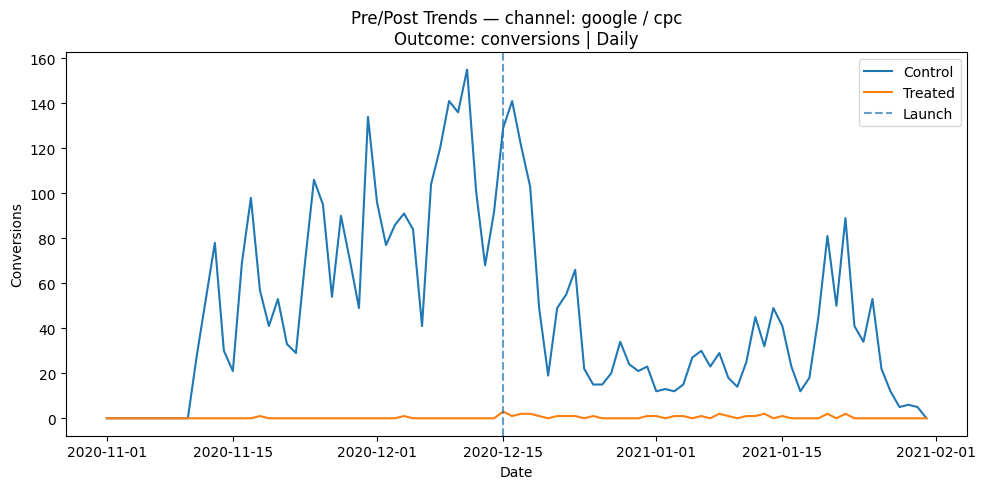

,Pre_Avg,Post_Avg
Control,60.204545,37.229167
Treated,0.045455,0.625


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ========= 1) CONFIGURE THE TEST HERE =========
# Choosing the treated group and the launch/change date.
# TREATED can be a channel (source/medium) or a specific campaign string.
USE_FIELD   = "channel"         # "channel" or "campaign"
TREATED_VAL = "google / cpc"    # e.g., "google / cpc" or a campaign name
LAUNCH_DATE = "2020-12-15"      # YYYY-MM-DD

# Outcome to test: "conversions" (count) or "revenue" (continuous)
OUTCOME = "conversions"

# Optional: aggregate to weekly to reduce daily noise (True/False)
AGG_WEEKLY = False
# ==============================================

# 2) Ensure event_date is datetime
df["event_date"] = pd.to_datetime(df["event_date"])

# 3) Label treated vs control and pre vs post
tmp = df.copy()
tmp["treated"] = (tmp[USE_FIELD].str.lower() == TREATED_VAL.lower()).astype(int)
tmp["post"]    = (tmp["event_date"] >= pd.Timestamp(LAUNCH_DATE)).astype(int)

# 4) Aggregate outcome at date x treated level
if AGG_WEEKLY:
    # Week start (Mon) to stabilize the series
    tmp["week"] = tmp["event_date"] - pd.to_timedelta(tmp["event_date"].dt.weekday, unit="D")
    grp_cols = ["week", "treated"]
    agg = tmp.groupby(grp_cols, as_index=False)[OUTCOME].sum()
    agg = agg.rename(columns={"week": "date"})
else:
    grp_cols = ["event_date", "treated"]
    agg = tmp.groupby(grp_cols, as_index=False)[OUTCOME].sum()
    agg = agg.rename(columns={"event_date": "date"})

# 5) Add a simple time trend
agg = agg.sort_values("date")
agg["date_num"] = agg["date"].rank(method="dense").astype(int)

# 6) Run DiD regression: OUTCOME ~ treated + post + treated:post + trend
# Merge in 'post' at the same date granularity
post_frame = (agg[["date"]].drop_duplicates()
              .assign(post = (lambda d: (d["date"] >= pd.Timestamp(LAUNCH_DATE)).astype(int))))
agg = agg.merge(post_frame, on="date", how="left")

formula = f"{OUTCOME} ~ treated + post + treated:post + date_num"
m = smf.ols(formula, data=agg).fit(cov_type="HC1")

print(f"=== Difference-in-Differences Result ({USE_FIELD}='{TREATED_VAL}', outcome='{OUTCOME}') ===")
print(m.summary().tables[1])  # Coeff table
did_effect = m.params.get("treated:post", np.nan)
print(f"\nEstimated DiD effect (treated×post): {did_effect:.4f}")

# 7) Plot treated vs control pre/post
plot_df = agg.copy()
pivot_plot = plot_df.pivot(index="date", columns="treated", values=OUTCOME).fillna(0)
pivot_plot.columns = ["Control", "Treated"]  # 0,1 -> labels

plt.figure(figsize=(10,5))
plt.plot(pivot_plot.index, pivot_plot["Control"], label="Control")
plt.plot(pivot_plot.index, pivot_plot["Treated"], label="Treated")
plt.axvline(pd.Timestamp(LAUNCH_DATE), linestyle="--", alpha=0.7, label="Launch")
plt.title(f"Pre/Post Trends — {USE_FIELD}: {TREATED_VAL}\nOutcome: {OUTCOME} | {'Weekly' if AGG_WEEKLY else 'Daily'}")
plt.xlabel("Date")
plt.ylabel(OUTCOME.capitalize())
plt.legend()
plt.tight_layout()
plt.show()

# 8) Quick pre/post averages table for intuition
pre = pivot_plot.loc[pivot_plot.index < pd.Timestamp(LAUNCH_DATE)].mean().rename("Pre_Avg")
post = pivot_plot.loc[pivot_plot.index >= pd.Timestamp(LAUNCH_DATE)].mean().rename("Post_Avg")
prepost = pd.concat([pre, post], axis=1)
display(prepost)

# Export code
agg.to_csv("/content/did_daily_conversions.csv", index=False)

coef_table = pd.DataFrame({
    "variable": m.params.index,
    "coef": m.params.values,
    "p_value": m.pvalues.values
})
coef_table.to_csv("/content/did_results.csv", index=False)

from google.colab import files
files.download("/content/did_daily_conversions.csv")
files.download("/content/did_results.csv")

**RFM segmentation + simple LTV**

In [26]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm

# Load customer table from BigQuery
PROJECT = "md-ga4-marketing-analysis"
DATASET = "ga4_campaign_data"
TABLE   = "dim_customers"

client = bigquery.Client(project=PROJECT)

sql = f"""
SELECT
  user_pseudo_id AS user_id,
  device_category,
  country,
  platform,
  first_seen_date,
  last_seen_date,
  recency_days,
  sessions_count,
  total_events,
  purchases_count,
  total_revenue,
  avg_order_value,
  purchase_per_session
FROM `{PROJECT}.{DATASET}.{TABLE}`
"""
dfc = client.query(sql).to_dataframe()

# 1) Clean types
for c in ["first_seen_date","last_seen_date"]:
    dfc[c] = pd.to_datetime(dfc[c], errors="coerce")
num_cols = ["recency_days","sessions_count","total_events","purchases_count","total_revenue",
            "avg_order_value","purchase_per_session"]
for c in num_cols:
    dfc[c] = pd.to_numeric(dfc[c], errors="coerce")

# 2) RFM features
#    R = Recency (days since last_seen) -> use provided recency_days if present, else recompute
if dfc["recency_days"].notna().any():
    R = dfc["recency_days"].fillna(dfc["recency_days"].median())
else:
    # fallback: compute from max(last_seen_date)
    anchor = dfc["last_seen_date"].max()
    R = (anchor - dfc["last_seen_date"]).dt.days.fillna((dfc["last_seen_date"].max() - dfc["last_seen_date"].min()).days)

F = dfc["purchases_count"].fillna(0)
M = dfc["total_revenue"].fillna(0)

rfm = pd.DataFrame({
    "user_id": dfc["user_id"],
    "Recency": R,                  # lower is better / more recent
    "Frequency": F,                # more orders
    "Monetary": M                  # more revenue
}).replace([np.inf, -np.inf], np.nan).fillna(0)

# 3) Scale + cluster (KMeans, k=4 by default)
X_rfm = StandardScaler().fit_transform(rfm[["Recency","Frequency","Monetary"]])
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
rfm["cluster"] = kmeans.fit_predict(X_rfm)

# 4) Human-friendly segment labels (rank by value)
rank_df = (rfm.groupby("cluster")
             .agg(M_mean=("Monetary","mean"),
                  R_mean=("Recency","mean"),
                  F_mean=("Frequency","mean"))
             .sort_values(["M_mean","F_mean","R_mean"], ascending=[False, False, True]))
labels = ["Loyal High-Value", "Growing/Promising", "Occasional Buyers", "Churn Risk / Low-Value"]
labels_map = {cl: (labels[i] if i < len(labels) else f"Segment {i+1}")
              for i, cl in enumerate(rank_df.index.tolist())}
rfm["segment_label"] = rfm["cluster"].map(labels_map)

# 5) Segment summaries
cluster_sizes = rfm["cluster"].value_counts().sort_index().rename("size")
cluster_profile = rfm.groupby("cluster")[["Recency","Frequency","Monetary"]].agg(["mean","median","std"])
segment_summary = (rfm.groupby(["cluster","segment_label"])
                     .agg(size=("user_id","count"),
                          Recency_mean=("Recency","mean"),
                          Frequency_mean=("Frequency","mean"),
                          Monetary_mean=("Monetary","mean"),
                          Monetary_sum=("Monetary","sum"))
                     .sort_values(["Monetary_sum","Monetary_mean"], ascending=False))

print("=== RFM Cluster Sizes ===")
display(cluster_sizes.to_frame())
print("=== RFM Cluster Profile ===")
display(cluster_profile)
print("=== Segment Summary (ranked by revenue contribution) ===")
display(segment_summary)

# 6) Simple LTV model (illustrative)
#    Label: use total_revenue as a proxy (swap in 90-day LTV if you create it later)
#    Predictors: early behavior proxies (cap outliers), plus exposure window since first_seen

# Ensure predictors and target are numeric floats
X = ltv_df[["early_sessions","early_events","early_purchases","days_since_first"]].apply(
    pd.to_numeric, errors="coerce"
).astype(float)

y = pd.to_numeric(ltv_df["revenue_total"], errors="coerce").astype(float)

# Drop rows with NaN or inf
mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X_clean = X[mask]
y_clean = y[mask]

# Add constant and fit OLS
X_const = sm.add_constant(X_clean)
ltv_model = sm.OLS(y_clean, X_const).fit(cov_type="HC1")

print("=== Simple LTV Model (OLS coefficients) ===")
display(pd.DataFrame({
    "variable": X_const.columns,
    "coef": ltv_model.params.values,
    "p_value": ltv_model.pvalues.values
}))


# 7) Join segments back to key dims for Tableau (optional enrich)
rfm_enriched = (rfm.merge(dfc[["user_id","device_category","country","platform"]], on="user_id", how="left"))

# 8) Save outputs
rfm.to_csv("/content/rfm_assignments.csv", index=False)
segment_summary.reset_index().to_csv("/content/rfm_segment_summary.csv", index=False)
rfm_enriched.to_csv("/content/rfm_enriched.csv", index=False)

# Build coef table aligned to the model's actual parameter index
coef_table = pd.DataFrame({
    "variable": ltv_model.params.index,          # includes 'const'
    "coef": ltv_model.params.values,
    "p_value": ltv_model.pvalues.values
})
coef_table.to_csv("/content/ltv_model_coefficients.csv", index=False)
coef_table


print("\nSaved files:")
print("• /content/rfm_assignments.csv")
print("• /content/rfm_enriched.csv")
print("• /content/rfm_segment_summary.csv")
print("• /content/ltv_model_coefficients.csv")

# Export code
rfm.to_csv("/content/rfm_assignments.csv", index=False)
segment_summary.reset_index().to_csv("/content/rfm_segment_summary.csv", index=False)
rfm_enriched.to_csv("/content/rfm_enriched.csv", index=False)
coef_table.to_csv("/content/ltv_model_coefficients.csv", index=False)

from google.colab import files
files.download("/content/rfm_assignments.csv")
files.download("/content/rfm_segment_summary.csv")
files.download("/content/rfm_enriched.csv")
files.download("/content/ltv_model_coefficients.csv")

=== RFM Cluster Sizes ===


,size
cluster,
0,145003
1,121392
2,214
3,3545


=== RFM Cluster Profile ===


Recency                    Frequency                   \
                mean  median        std      mean median       std   
cluster                                                              
0        1735.943801  1734.0  14.385841       0.0    0.0       0.0   
1        1691.798306  1691.0  11.845102       0.0    0.0       0.0   
2        1716.023364  1720.0  21.364145  2.658879    2.0  2.405098   
3        1714.395769  1719.0  22.210831  1.099295    1.0  0.404911   

           Monetary                     
               mean median         std  
cluster                                 
0          0.101350    0.0    2.644850  
1          0.006401    0.0    0.602612  
2        435.957944  371.0  240.578398  
3         71.547250   55.0   55.470846

=== Segment Summary (ranked by revenue contribution) ===


,,size,Recency_mean,Frequency_mean,Monetary_mean,Monetary_sum
cluster,segment_label,,,,,
3,Growing/Promising,3545,1714.395769,1.099295,71.547250,253635.0
2,Loyal High-Value,214,1716.023364,2.658879,435.957944,93295.0
0,Occasional Buyers,145003,1735.943801,0.0,0.101350,14696.0
1,Churn Risk / Low-Value,121392,1691.798306,0.0,0.006401,777.0


=== Simple LTV Model (OLS coefficients) ===


,variable,coef,p_value
0,const,-0.997382,7.196939e-17
1,early_sessions,0.191931,5.194967e-02
2,early_events,0.043553,6.136275e-19
3,early_purchases,70.663657,4.764456e-202
4,days_since_first,0.006570,3.598924e-15



Saved files:
• /content/rfm_assignments.csv
• /content/rfm_enriched.csv
• /content/rfm_segment_summary.csv
• /content/ltv_model_coefficients.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>